In [1]:
import argparse
import torch

import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos
    # cfg.USE_CUDA = False
    
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/vlcs/ridg/sun', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default=' caltech pascal labelme'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['sun'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/vlcs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/vlcs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='RIDG', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [4]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

trainer = build_trainer(cfg, args)

Setting fixed seed: 1
Loading trainer: RIDG
Loading dataset: VLCS
Building transform_train
+ resize to 224x224
+ random flip
+ random translation
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_test
+ resize to 224x224
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
***** Dataset statistics *****
  Dataset: VLCS
  Source domains: ['caltech', 'pascal', 'labelme']
  Target domains: ['sun']
  # classes: 5
  # train_x: 4,690
  # val: 523
  # test: 985
Building model
Backbone: resnet18
# params: 11,179,077
Loading evaluator: Classification


In [5]:
trainer.load_model(cfg.OUTPUT_DIR, epoch=50)

Loading weights to model from "../output/dg/vlcs/ridg/sun/model/model.pth.tar-50" (epoch = 50)


In [6]:
id_feats = []
id_labels = []
train_loader_x = trainer.train_loader_x
for idx, batch in enumerate(train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    features = trainer.model.backbone(images)
    id_feats.extend(features.detach().cpu().numpy())
    id_labels.extend(label.detach().cpu().numpy())

In [7]:
od_feats = []
od_labels = []
test_loader = trainer.test_loader
for idx, batch in enumerate(test_loader):
    images, label = trainer.parse_batch_train(batch)
    features = trainer.model.backbone(images)
    od_feats.extend(features.detach().cpu().numpy())
    od_labels.extend(label.detach().cpu().numpy())

In [8]:
id_feats = np.array(id_feats)
id_labels = np.array(id_labels)
od_feats = np.array(od_feats)
od_labels = np.array(od_labels)

In [9]:
# id_label = np.array([0 for _ in range(len(selected_id_feats))])
# od_label = np.array([1 for _ in range(len(selected_od_feats))])
# total_label = np.hstack((id_label, od_label))

In [10]:
# tsne_data = np.vstack((selected_id_feats, selected_od_feats))
# tsne = TSNE(n_components=2)
# transformed_data = tsne.fit_transform(tsne_data)

In [11]:
# scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_label)
# plt.title('Visualize features of in and out domain')
# plt.show()

In [9]:
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(id_feats)

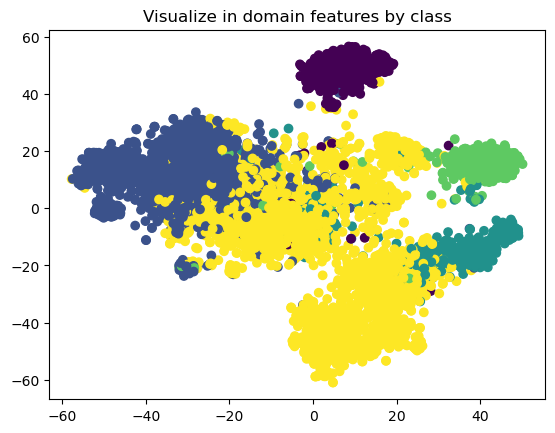

In [10]:
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=id_labels)
plt.title('Visualize in domain features by class')
plt.show()

In [11]:
features_id_indexes = []
features_od_indexes = []

In [12]:
def has_intersection(arr1, arr2):
    return any(element in arr2 for element in arr1)

In [14]:
print('-------------')
for j in range(5):
    selected_class = j
    selected_noise_id_feats = id_feats[id_labels == 10]
    selected_id_feats = id_feats[id_labels == selected_class]
    selected_od_feats = od_feats[od_labels == selected_class]
    x = np.arange(0, 512)
    mean_impact = np.zeros(512)
    # for j in range(64):
    for i in range(len(selected_id_feats)):
        selected_class_weight = trainer.model.classifier.weight[selected_class].detach().cpu().numpy()
        feats_impact = selected_class_weight * (selected_id_feats[i])
        mean_impact += feats_impact
    mean_impact /= len(selected_id_feats)
    idxes = np.argpartition(mean_impact, -3)[-3:]
    features_id_indexes.append(idxes)
    print(f'Top 3 largest value of class {j}: {idxes} - Value: {mean_impact[idxes]} - Total value: {np.sum(mean_impact)}')
    # plt.plot(x, mean_impact)
    # plt.title(f'Impact of class {selected_class} weights')
    # plt.show()

In [15]:
most_impact_feats = [[17, 316, 255], [32, 182, 400], [484, 364, 194], [333, 153, 280], [309, 504, 226]]
impact_id_sets = [set(), set(), set(), set(), set()]
impact_od_sets = [set(), set(), set(), set(), set()]

In [17]:
print('-------------')
for j in range(5):
    selected_class = j
    selected_noise_id_feats = id_feats[id_labels == 10]
    selected_id_feats = id_feats[id_labels == selected_class]
    selected_od_feats = od_feats[od_labels == selected_class]
    x = np.arange(0, 512)
    mean_impact = np.zeros(512)
    for i in range(len(selected_id_feats)):
        selected_class_weight = trainer.model.classifier.weight[selected_class].detach().cpu().numpy()
        feats_impact = selected_class_weight * (selected_id_feats[i])
        idxes = np.argpartition(feats_impact, -1)[-1:]
        impact_id_sets[j].update(idxes.tolist())
        print(f'Top 3 largest value of class {j} of element {i}: {idxes} - Value: {feats_impact[idxes]} - Total value: {np.sum(feats_impact)}')

In [18]:
for i in range(5):
    for j in range(5):
        if i != j:
            union_feats = impact_id_sets[i].intersection(impact_id_sets[j])
            print(f'Same impact features of class {i} and {j}: {union_feats}')

In [19]:
for i in range(5):
    union_feats = impact_id_sets[i].intersection(impact_od_sets[i])
    print(f'impact features of class {i}: {union_feats}')

In [18]:
def all_unique(lst):
    return len(lst) == len(set(lst))

In [19]:
def find_duplicate_indices(arr):
    unique_elements, indices = np.unique(arr, return_index=True)
    duplicates = {}

    for element in unique_elements:
        # Find the indices where each unique element appears in the original array
        element_indices = np.where(arr == element)[0]
        
        if len(element_indices) > 1:
            duplicates[element] = element_indices.tolist()
    
    return duplicates

In [20]:
def find_duplicate_sublists(lst):
    seen = set()
    duplicates = []

    for sublist in lst:
        # Convert sublist to tuple because lists are not hashable and cannot be added to a set
        sublist_tuple = tuple(sublist)
        if sublist_tuple in seen:
            duplicates.append(sublist)
        else:
            seen.add(sublist_tuple)
    
    return duplicates

In [12]:
features_id_indexes = np.array(features_id_indexes)
features_od_indexes = np.array(features_od_indexes)

In [24]:
find_duplicate_indices(features_id_indexes)

{}

In [13]:
same_impact = np.where(features_id_indexes == features_od_indexes)[0]

In [14]:
len(same_impact)

9

In [6]:
# id_mean = []
# id_std = []
# id_domains = []
# id_labels = []
# id_feats = []
# train_loader_x = trainer.train_loader_x
# for idx, batch in enumerate(train_loader_x):
#     images, label, domain = trainer.parse_batch_train(batch)
#     domain = batch['domain']
#     style_feat = trainer.model.backbone.stylemaps(images, store_feature=True, apply_conststyle=True)
#     class_feat = trainer.model.backbone.featuremaps(images, store_feature=True, apply_conststyle=True)
#     style_feat = style_feat.detach().cpu().numpy()
#     print(f'shape: {style_feat.shape}')
#     mean = np.mean(style_feat, axis=(2, 3))
#     std = np.std(style_feat, axis=(2, 3))
#     id_mean.extend(mean)
#     id_std.extend(std)
#     id_domains.extend(domain.numpy())
#     id_labels.extend(label.detach().cpu().numpy())
#     id_feats.extend(class_feat.detach().cpu().numpy())
# total_id_feats = len(id_domains)

In [6]:
id_mean = []
id_std = []
id_domains = []
id_labels = []
id_feats = []
train_loader_x = trainer.train_loader_x
for idx, batch in enumerate(train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    domain = batch['domain']
    style_feat = trainer.model.backbone.stylemaps(images)
    class_feat = trainer.model.backbone.featuremaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    id_mean.extend(mean)
    id_std.extend(std)
    id_domains.extend(domain.numpy())
    id_labels.extend(label.detach().cpu().numpy())
    id_feats.extend(class_feat.detach().cpu().numpy())
total_id_feats = len(id_domains)

In [7]:
od_mean = []
od_std = []
od_domains = []
od_labels = []
od_feats = []
test_loader = trainer.test_loader
for idx, batch in enumerate(test_loader):
    images, label = trainer.parse_batch_test(batch)
    style_feat = trainer.model.backbone.stylemaps(images)
    class_feat = trainer.model.backbone.featuremaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    od_mean.extend(mean)
    od_std.extend(std)
    od_domains.extend([3 for i in range(len(label))])
    od_labels.extend(label.detach().cpu().numpy())
    od_feats.extend(class_feat.detach().cpu().numpy())
total_od_feats = len(od_domains)

# for idx, conststyle in enumerate(trainer.model.backbone.conststyle):
#     if idx == 3:
#         od_mean.extend(conststyle.mean)
#         od_std.extend(conststyle.std)

In [8]:
id_domains = np.array(id_domains)
od_domains = np.array(od_domains)
total_domains = np.hstack((id_domains, od_domains))
id_labels = np.array(id_labels)
od_labels = np.array(od_labels)
total_labels = np.hstack((id_labels, od_labels))

In [9]:
od_mean = np.array(od_mean)
od_std = np.array(od_std)
id_mean = np.array(id_mean)
id_std = np.array(id_std)
id_feats = np.array(id_feats)
od_feats = np.array(od_feats)
total_feats = np.vstack((id_feats, od_feats))
total_mean = np.vstack((id_mean, od_mean))
total_std = np.vstack((id_std, od_std))

In [10]:
feats_mean = np.mean(total_feats, axis=(2, 3))
feats_std = np.std(total_feats, axis=(2, 3))

In [12]:
tsne_data = np.hstack((total_mean, total_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

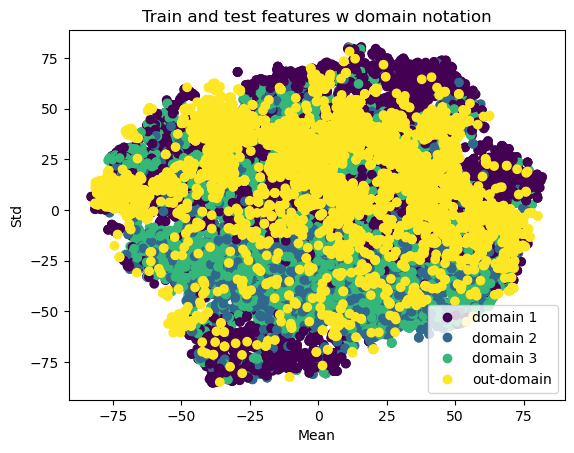

In [14]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train and test features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [16]:
tsne_data = np.hstack((id_mean, id_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

In [29]:
len(total_labels)

5853

ValueError: 'c' argument has 5853 elements, which is inconsistent with 'x' and 'y' with size 797.

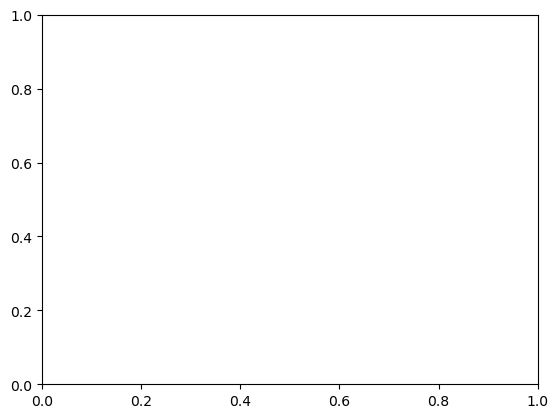

In [27]:
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [16]:
id_feats_mean = np.mean(id_feats, axis=(2, 3))
id_feats_std = np.std(id_feats, axis=(2, 3))
tsne_data = np.hstack((id_feats_mean, id_feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

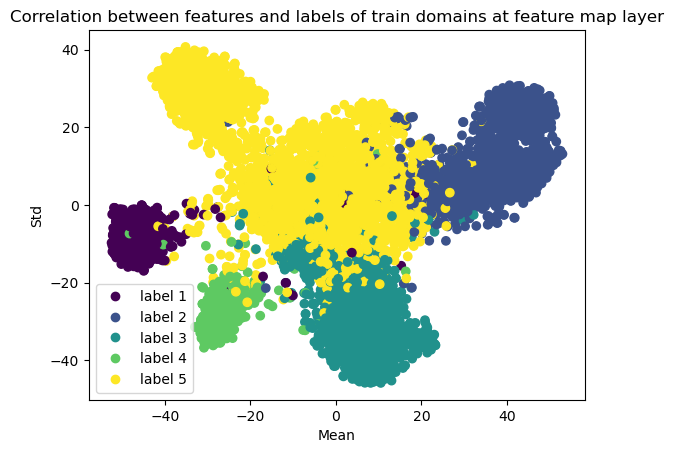

In [17]:
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=id_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)
plt.title('Correlation between features and labels of train domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [18]:
col_val = []
for i in range(0,3):
    domain_index = np.where(id_domains == i)[0]
    c_labels = id_labels[domain_index]
    val, counts = np.unique(c_labels, return_counts=True)
    col_val.append(counts)

In [19]:
col_val

[array([208, 438, 269, 265, 941]),
 array([ 13, 585, 646,  19, 789]),
 array([148,  77,  75,  42, 541])]

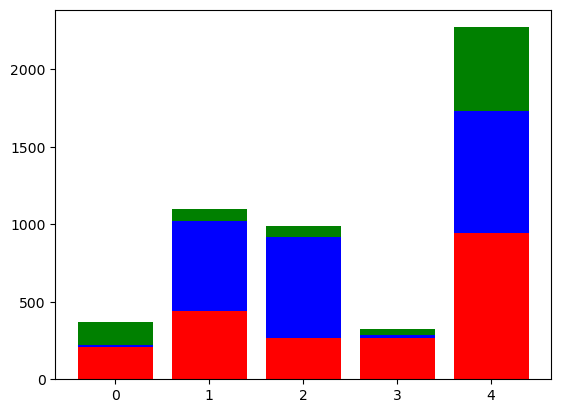

In [20]:
x = [i for i in range(5)]
plt.bar(x, col_val[0], color='r')
plt.bar(x, col_val[1], bottom=col_val[0], color='b')
plt.bar(x, col_val[2], bottom=col_val[1]+col_val[0], color='g')
plt.show()

In [21]:
val, counts = np.unique(od_labels, return_counts=True)

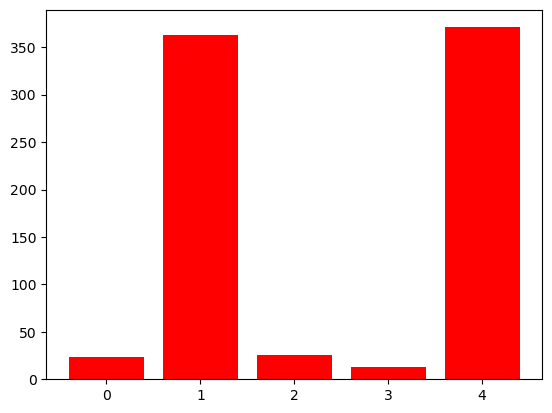

In [22]:
x = [i for i in range(5)]
plt.bar(x, counts, color='r')
plt.show()

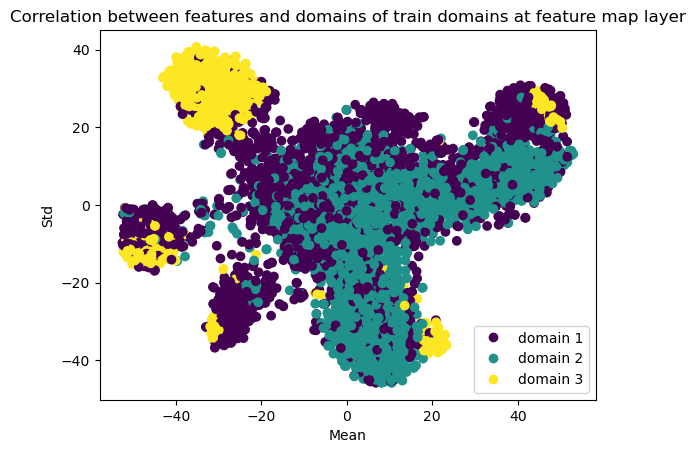

In [23]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=id_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Correlation between features and domains of train domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [24]:
od_feats_mean = np.mean(od_feats, axis=(2, 3))
od_feats_std = np.std(od_feats, axis=(2, 3))
tsne_data = np.hstack((od_feats_mean, od_feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

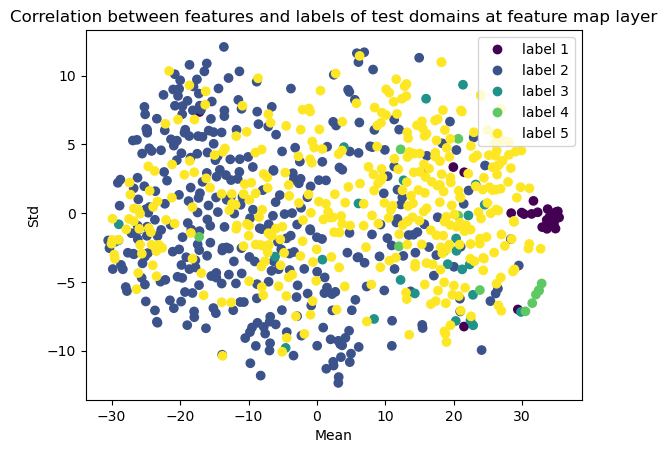

In [25]:
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=od_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)
plt.title('Correlation between features and labels of test domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [26]:
od_feats_mean = np.mean(od_feats, axis=(2, 3))
od_feats_std = np.std(od_feats, axis=(2, 3))
tsne_data = np.hstack((od_feats_mean, od_feats_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

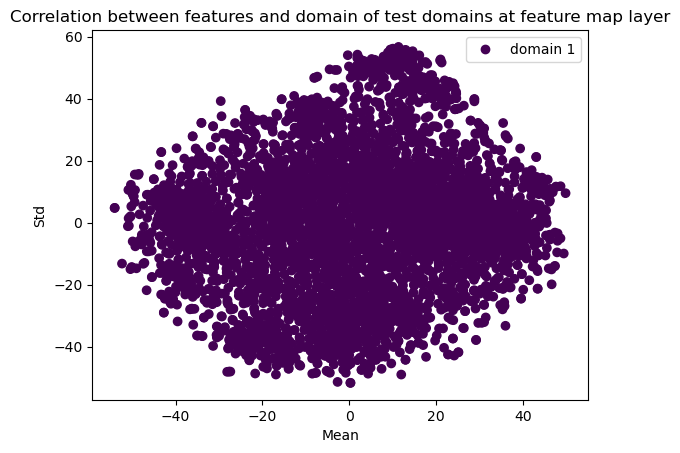

In [28]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=od_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Correlation between features and domain of test domains at feature map layer')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()